# Customer Complaint - CFPB
Tian Yang

## Exploratory Data Analysis (Round 1)

### 1. Import  packages

In [75]:
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Basic operations
import numpy as np
import pandas as pd
import scipy as sp
import math

# Visualizations
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Sklearn package sets
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

# Machine learning
import lightgbm as lgb
import xgboost as xgb

# Dealing with datetime features
from datetime import *

# Timer
import time

### 2. Load data

Read in and take a peek at our data.

In [2]:
data = pd.read_csv('./Consumer_Complaints.csv')
data.shape

(871873, 18)

In [3]:
origin_col = data.columns
origin_col

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

We could find that there are some spaces, '-' and '?' in column names. It's not convenient for operations later, so we would like to drop them. 

In [4]:
# Delete spaces in original feature names.
data.columns = ['Date_received', 'Product', 'Sub_product', 'Issue', 'Sub_issue',
       'Consumer_complaint_narrative', 'Company_public_response', 'Company',
       'State', 'ZIP_code', 'Tags', 'Is_Consumer_consent_provided',
       'Submitted_via', 'Date_sent_to_company', 'Company_response_to_consumer',
       'Is_Timely_response', 'Is_Consumer_disputed', 'Complaint_ID']

In [6]:
data.head(3)

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,ZIP_code,Tags,Is_Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Is_Timely_response,Is_Consumer_disputed,Complaint_ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,10/01/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/05/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100


We could find that except two highly correlated datetime features, almost all features are categorical.



### 3. Statistical summaries and visualizations

To understand the data we are now going to consider some key facts about these features including their relationship with the label 'Is_Timely_response'. <br><br>
Now let's start with label.

#### 3.1 Label

Our label only has two values, 'Yes' or 'No'. 'Yes' means the company responsed to customer's compliant in time, and
'No' means they didn't. <br>

Let's simply count their numbers and calculate the response rate.

In [7]:
label = pd.DataFrame(data.Is_Timely_response.value_counts())
label.columns = ['Timely_response_cnt']
label['Timely_response_rate'] = label.Timely_response_cnt/data.shape[0]

base = 0.972434

label

,Timely_response_cnt,Timely_response_rate
Yes,847839,0.972434
No,24034,0.027566


In the whole data set, we have over 97% labeled as 1. This data set is unbalanced.

We need to calculate mean timely response rate later, so for our convenience we encode 'Yes' as 1 and 'No' as 0, and change the data type to 'int' for now.

In [8]:
data.Is_Timely_response[data.Is_Timely_response == 'Yes'] = 1
data.Is_Timely_response[data.Is_Timely_response == 'No'] = 0

data.Is_Timely_response = data.Is_Timely_response.astype('int')

#### 3.2 Missing Values

Then let's check missing values in our data. We will come up with a table inculding missing value counts and ratio in each features.

In [9]:
na = pd.DataFrame(data.isnull().sum())
na.columns = ['na']
na['na%'] = na.na/data.shape[0]
na = na.sort(columns='na%', ascending=False)
na

,na,na%
Tags,750232,0.860483
Consumer_complaint_narrative,687970,0.789071
Company_public_response,629530,0.722043
Is_Consumer_consent_provided,528190,0.605811
Sub_issue,472174,0.541563
Sub_product,235160,0.269718
Is_Consumer_disputed,103319,0.118502
ZIP_code,11265,0.012920
State,11216,0.012864
Date_sent_to_company,0,0.000000


For those features that have too many missing values, let's say over 50%, we could just delete them. Because they could not provide enough infomation to us, and those NAs would decrease the accuracy of our model. <br>

But just in case, let's still have a look at these features.<br>

** Tags & Is_Consumer_consent_provided**

In [10]:
consent = data.Is_Consumer_consent_provided
tag = data.Tags

# Take data without misisng values
data_tag = data[-tag.isnull()]
data_consent = data[-consent.isnull()]

'Tags' doesn't make any difference to timely response, so dose 'Is_Consumer_consent_provided'. So they are not significant. Just delete these columns.

In [11]:
data_tag[['Tags', 'Is_Timely_response']].groupby('Tags').mean()

,Is_Timely_response
Tags,
Older American,0.976469
"Older American, Servicemember",0.972337
Servicemember,0.964778


In [12]:
data_consent[['Is_Consumer_consent_provided', 'Is_Timely_response']].groupby('Is_Consumer_consent_provided').mean()

,Is_Timely_response
Is_Consumer_consent_provided,
Consent not provided,0.969455
Consent provided,0.962594
Consent withdrawn,0.979070
Other,0.974870


---------

#### 3.3 Product & Sub-product

** Product **<br>

We could see that the response rate varies, which is good. And we could even measure it more precisely by calculating timely response rate of each products over average.

In [21]:
#data.Product.value_counts()

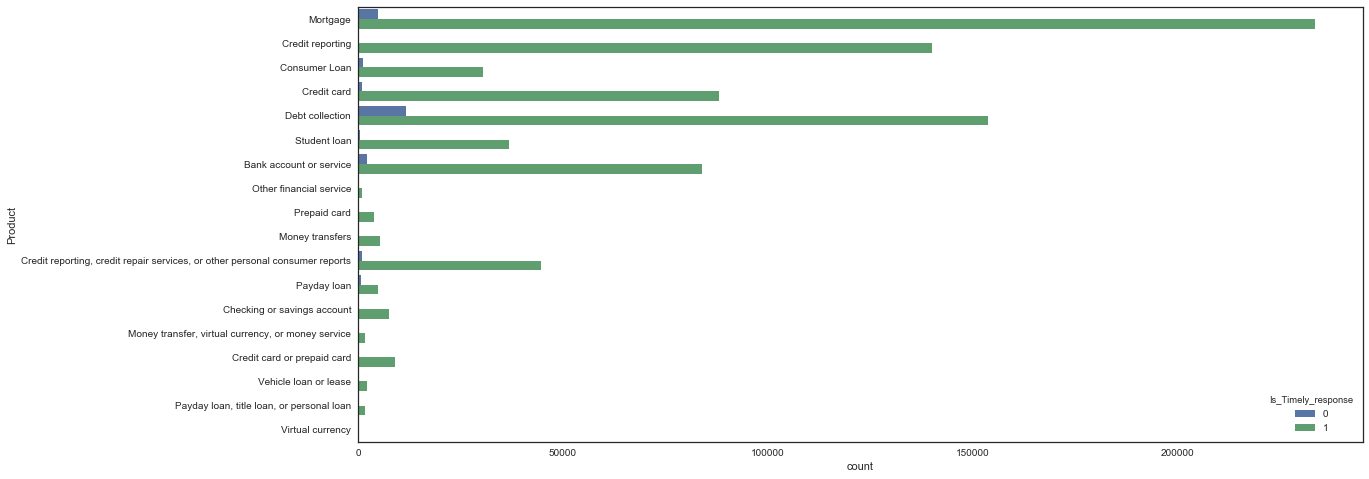

In [32]:
f,ax=plt.subplots(figsize=(18,8))
sns.countplot(y = 'Product', hue='Is_Timely_response', data=data)
plt.show()

The rate of 0 is obviously higher in 'Debt collection'.
<br>
 

In this table, 'Timely_response' = (number of 1 in each 'Product') / (number of each 'Product');<br> 
'over_avg' = 'Timely_response' / base.<br>

So, 'over_avg' = 1 means there's no difference between this product and average, and the farther 'over_avg' is away from 1 means larger varience.
<br>


In [89]:
# Timely_response is the ratio of 'Is_Timely_response' = 1 over all. over_avg is the ratio / base.
tr_product = pd.DataFrame(data[['Product','Is_Timely_response']].groupby(['Product']).mean())
tr_product['over_avg'] = tr_product.Is_Timely_response / 0.972434
tr_product.sort('Is_Timely_response',ascending=False)

,Is_Timely_response,over_avg
Product,,
Credit reporting,0.997871,1.026158
Credit card or prepaid card,0.993201,1.021356
Credit card,0.988980,1.017015
Student loan,0.987085,1.015067
Prepaid card,0.987023,1.015003
Checking or savings account,0.986320,1.014279
"Money transfer, virtual currency, or money service",0.985304,1.013235
"Credit reporting, credit repair services, or other personal consumer reports",0.981542,1.009367
Mortgage,0.979330,1.007092


Here is an interesting finding. From this plot we could see that there're two peaks in the response rate density curve (Blue). One is slightly over base, which is 0.972434, and one is set around 0.89.

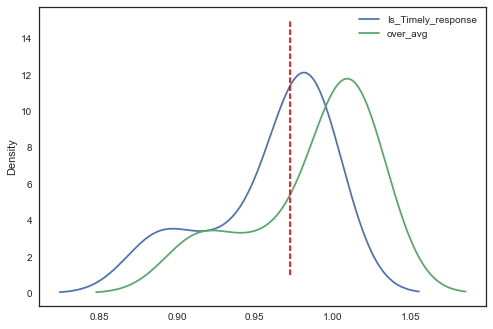

In [91]:
tr_product.plot.density()

yy = np.linspace(1,15,200)
tr_base = np.array([0.972434 for i in range(len(yy))])
plt.plot(tr_base, yy, 'r--')

plt.show()

** Sub_product **<br>

'Is_Timely_response' means the rate of 1 in each sub-product over baseline;<br>
'cnt%' means the appearance frequency of each sub-product.

In [18]:
subprod = pd.DataFrame(data[['Sub_product','Is_Timely_response']].groupby(['Sub_product']).mean())
subprod.Is_Timely_response = subprod.Is_Timely_response/base
subprod_cnt = data['Sub_product'].value_counts()/len(data['Sub_product'])
subprod['cnt%'] = subprod_cnt
subprod.columns = ['Is_Timely_response_over_avg','cnt%']

subprod.sort(columns='cnt%',ascending=False)

,Is_Timely_response_over_avg,cnt%
Sub_product,,
Other mortgage,1.007004,0.099361
Conventional fixed mortgage,1.007042,0.080991
Checking account,1.005323,0.074228
"Other (i.e. phone, health club, etc.)",0.958714,0.051103
Credit reporting,1.010167,0.050993
I do not know,0.939909,0.038490
Credit card,0.989978,0.032922
FHA mortgage,1.005141,0.029987
Conventional adjustable mortgage (ARM),1.007725,0.029112


In [19]:
#notknow = data[data['Sub-product'] == 'I do not know']
#notknow.Product.value_counts()
#debtc = data[data.Product == 'Debt collection']
#debtc['Sub-product'].value_counts()

subpnull = data[data['Sub_product'].isnull()]
subpnull = pd.DataFrame(subpnull.Product.value_counts())
print(subpnull)

fill_subprod_as_prod = list(subpnull.index)

                  Product
Credit reporting   140424
Credit card         89190
Payday loan          5546


There are some difference in 'Sub_product', and the missing values in Sub-product are all from Credit reporting, Credit card or Payday loan. And we could find out that these 3 products don't have sub-product. So it's easy to fill all missing values. We could just assign their sub-product as the same as products. <br>

But since 'Sub_product' is covered by 'Product', whether to keep this feature is stil not decided. 

---

#### 3.4 Issue & Sub-issue
<br>
There are 166 kinds of issues. A little bit much but acceptable. We could find that there are some issues have 100% response rate, and the lowest one is only 66.67%. For those have 100% response rate, it may due to their low base number. Just leave it for now and dig deeper in feature engineering part.

In [20]:
pd.DataFrame(data.Issue.value_counts()).shape

(166, 1)

In [21]:
iss = pd.DataFrame(data[['Issue','Is_Timely_response']].groupby(['Issue']).mean())
iss = iss.sort(columns='Is_Timely_response',ascending=False)
iss

,Is_Timely_response
Issue,
Problem with cash advance,1.000000
Lender damaged or destroyed vehicle,1.000000
Problem with an overdraft,1.000000
Convenience checks,1.000000
Problem with credit report or credit score,1.000000
Problem with overdraft,1.000000
Property was damaged or destroyed property,1.000000
Property was sold,1.000000
"Overdraft, savings, or rewards features",1.000000


The only peak appears around 1.0, seems like 0.98-0.99.

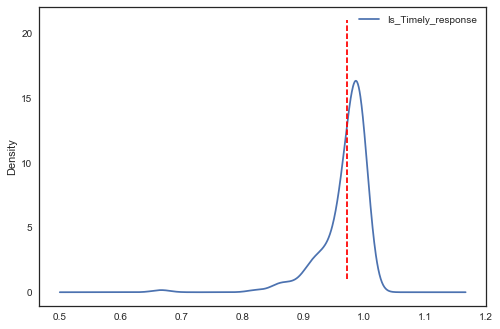

In [55]:
iss.plot.density()

yy = np.linspace(1,21,200)
tr_base = np.array([0.972434 for i in range(len(yy))])
plt.plot(tr_base, yy, 'r--')

plt.show()

** Sub-issue **
<br>
The missing values in 'Sub_issue' is also easy to fill. Since most of Issues do not have a sub_issue, so we could fill NAs with there Issues, Just like Sub_product. So let's leave this part here and consider this in feature engineering.

In [22]:
subissnull = pd.DataFrame(data[data['Sub_issue'].isnull()].Issue.value_counts())
subissnull.columns = ['null_subIssue']
subisn_index = list(subissnull.index)

issue = pd.DataFrame(data.Issue.value_counts())
issue = pd.concat([subissnull, issue], axis = 1)

issue['fillIssue'] = issue.null_subIssue - issue.Issue
issue = issue.fillna(0)

fill_subissue_as_other = list(issue[issue.fillIssue != 0].index)
fill_subissue_as_issue = list(issue[issue.fillIssue == 0].index)

In [23]:
fill_subissue_as_other

['Credit monitoring or identity theft protection services',
 'Getting a loan',
 'Improper use of your report',
 'Incorrect information on your report',
 'Managing the loan or lease',
 'Other features, terms, or problems',
 'Problem when making payments',
 "Problem with a credit reporting company's investigation into an existing problem",
 'Problem with credit report or credit score',
 'Struggling to pay your loan',
 'Unable to get your credit report or credit score']

In [24]:
fill_subissue_as_issue

['APR or interest rate',
 'Account opening, closing, or management',
 'Account terms and changes',
 'Adding money',
 'Advertising',
 'Advertising and marketing',
 'Advertising and marketing, including promotional offers',
 'Advertising, marketing or disclosures',
 'Application processing delay',
 'Application, originator, mortgage broker',
 'Applied for loan/did not receive money',
 'Applying for a mortgage',
 'Applying for a mortgage or refinancing an existing mortgage',
 'Arbitration',
 'Attempts to collect debt not owed',
 'Balance transfer',
 'Balance transfer fee',
 'Bankruptcy',
 'Billing disputes',
 'Billing statement',
 "Can't contact lender",
 "Can't contact lender or servicer",
 "Can't repay my loan",
 "Can't stop charges to bank account",
 "Can't stop withdrawals from your bank account",
 'Cash advance',
 'Cash advance fee',
 'Charged bank acct wrong day or amt',
 "Charged fees or interest I didn't expect",
 "Charged fees or interest you didn't expect",
 'Closing an account'

#### 3.5 Company
<br>
4409 is too much.. We could encode this feature based on company size, but domain knowledge is needed. Or other dataset about these companies also helps.

In [25]:
pd.DataFrame(data.Company.value_counts()).shape

(4409, 1)

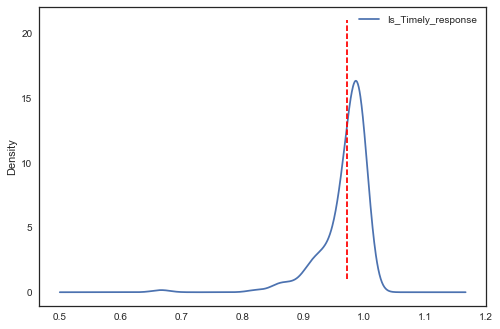

In [26]:
cmpy = pd.DataFrame(data[['Company','Is_Timely_response']].groupby(['Company']).mean())
cmpy = iss.sort(columns='Is_Timely_response',ascending=False)

cmpy.plot.density()

yy = np.linspace(1,21,200)
tr_base = np.array([0.972434 for i in range(len(yy))])
plt.plot(tr_base, yy, 'r--')

plt.show()

#### 3.6 State
<br>
The response rate measured by states is more like a norminal distribution than other features do. Three peaks, around 0.945, 0.97 and 1.

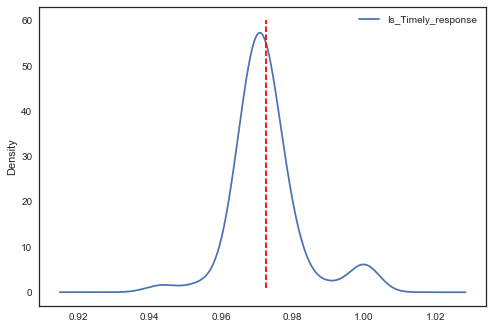

In [66]:
stt.plot.density()

yy = np.linspace(1,60,200)
tr_base = np.array([0.972434 for i in range(len(yy))])
plt.plot(tr_base, yy, 'r--')
plt.show()

#### 3.7 Submitted_via
<br>
This feature only has 6 categories. We could use one-hoting encoding to deal with it. But the variance is very low. The flunctuation is less than 1%.

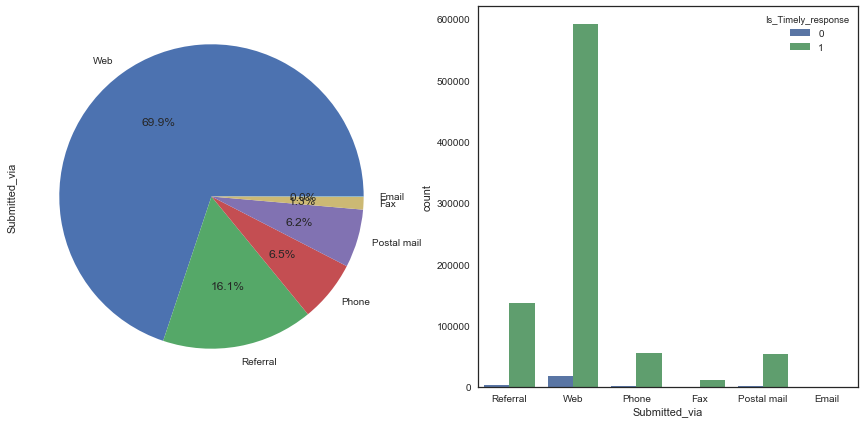

In [71]:
f,ax=plt.subplots(1,2,figsize=(15,7))

data.Submitted_via.value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0])
sns.countplot('Submitted_via',hue='Is_Timely_response',data=data,ax=ax[1])

plt.show()

In [73]:
tr_submit = pd.DataFrame(data[['Submitted_via','Is_Timely_response']].groupby(['Submitted_via']).mean())
tr_submit['over_avg'] = tr_submit.Is_Timely_response / 0.972434
tr_submit

,Is_Timely_response,over_avg
Submitted_via,,
Email,0.971429,0.998966
Fax,0.974981,1.002619
Phone,0.968572,0.996028
Postal mail,0.981627,1.009454
Referral,0.979539,1.007306
Web,0.970298,0.997803


#### 3.8 Company_response_to_consumer
<br>
There are only 8 categories. Using One-hot to encode. But better than 'Submitted_via', there are response rate like 0, 0.9266. 

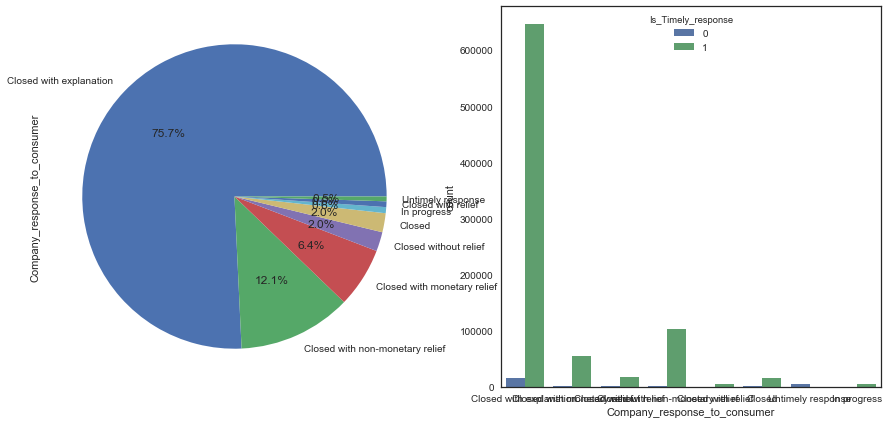

In [74]:
f,ax=plt.subplots(1,2,figsize=(15,7))

data.Company_response_to_consumer.value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0])
sns.countplot('Company_response_to_consumer',hue='Is_Timely_response',data=data,ax=ax[1])

plt.show()

In [75]:
tr_c2c = pd.DataFrame(data[['Company_response_to_consumer','Is_Timely_response']].groupby(['Company_response_to_consumer']).mean())
tr_c2c['over_avg'] = tr_c2c.Is_Timely_response / 0.972434
tr_c2c

,Is_Timely_response,over_avg
Company_response_to_consumer,,
Closed,0.901141,0.926686
Closed with explanation,0.977466,1.005175
Closed with monetary relief,0.985123,1.013048
Closed with non-monetary relief,0.986075,1.014028
Closed with relief,0.965498,0.992867
Closed without relief,0.971122,0.998650
In progress,0.999821,1.028163
Untimely response,0.000000,0.000000


---

#### 3.9 Is_Consumer_Disputed
<br>
Two categories, no obvious pattern. Could try some combinations with other features.

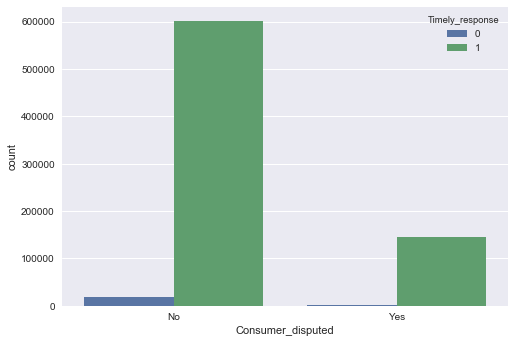

In [37]:
sns.countplot('Consumer_disputed',hue='Timely_response',data=data)
plt.show()

In [76]:
tr_disp = pd.DataFrame(data[['Is_Consumer_disputed','Is_Timely_response']].groupby(['Is_Consumer_disputed']).mean())
tr_disp['over_avg'] = tr_disp.Is_Timely_response / 0.972434
tr_disp

,Is_Timely_response,over_avg
Is_Consumer_disputed,,
No,0.969160,0.996634
Yes,0.982679,1.010536


### 4. Dealing with missing values
<br>
Shape before: (871873, 18)
<br>

- Delete features having over 50% NAs 
- Delete 'Sub_product' for now
- Fill NAs in 'Is_Consumer_disputed' with 'NotKnow'
- Delete rows containing NAs in 'ZIP_code' and 'State'
<br>

Shape after: (860606, 12)

In [27]:
# Delete features having over 50% NAs
xcol = list(na[na['na%'] > 0.5].index)
data = data.drop(xcol, 1)

# Delete 'Sub_product'
data = data.drop('Sub_product', 1)

In [28]:
# Fill NAs in 'Is_Consumer_disputed' with 'NotKnow'
data.Is_Consumer_disputed[data.Is_Consumer_disputed.isnull()] = 'NotKnow'

# delete NA rolls in ZIP_code and State.
data = data.dropna()
data.shape

(860606, 12)

In [29]:
na = pd.DataFrame(data.isnull().sum())
na.columns = ['na']
na['na%'] = na.na/data.shape[0]
na = na.sort(columns='na%', ascending=False)
na

,na,na%
Date_received,0,0.0
Product,0,0.0
Issue,0,0.0
Company,0,0.0
State,0,0.0
ZIP_code,0,0.0
Submitted_via,0,0.0
Date_sent_to_company,0,0.0
Company_response_to_consumer,0,0.0
Is_Timely_response,0,0.0


In [30]:
pd.DataFrame(data.dtypes)

,0
Date_received,object
Product,object
Issue,object
Company,object
State,object
ZIP_code,object
Submitted_via,object
Date_sent_to_company,object
Company_response_to_consumer,object
Is_Timely_response,int64


## Exploratory Data Analysis (Round 2)

### 3. Chi Square Test (i.v. & d.v.)

In Chi Square Test, for p value, the smaller the better. And in our case all p values for 'Is_Timely_response' = 'No' is small, which means all features have some relationships with 'Is_Timely_response'.

In [34]:
def chi_square_test(S1, S2):
    crs_tab = pd.crosstab(S1, S2, margins=True)
    dim = crs_tab.shape[0]-1
    
    obs = crs_tab.ix[0:dim,0:2]
    
    exp =  np.outer(crs_tab["All"][0:dim], crs_tab.ix["All"][0:2]) / 860606
    exp = pd.DataFrame(exp)
    exp.index = obs.index
    
    res = sp.stats.chisquare(obs,exp)
    p_value = res.pvalue
    chi = res.statistic
    
    r = pd.DataFrame({'p_value': p_value, 'cs': chi})
   
    return r

In [35]:
p = []
index = []
data1 = data.drop(['Is_Timely_response','Complaint_ID'], axis=1)
label = data.Is_Timely_response

for col in data1:
    cs = chi_square_test(data1['%s'%col], label)
    index.append(col)
    p.append(cs.p_value[0])

cs_test = pd.DataFrame(index=index, data=p)
cs_test.columns=['p_value']
cs_test = cs_test.sort('p_value')
cs_test

,p_value
Date_received,0.000000e+00
Product,0.000000e+00
Issue,0.000000e+00
Company,0.000000e+00
Date_sent_to_company,0.000000e+00
Company_response_to_consumer,0.000000e+00
Is_Consumer_disputed,9.864516e-193
Submitted_via,5.549706e-118
State,1.293602e-61
ZIP_code,1.480492e-09


### 4. Mutual Infomation (d.v. & i.d.)

The relevances between features and 'Is_Timely_response' are listed below. For 'Is_Timely_response' = 'No, 'ZIP_code' has the lowest relevance.

In [36]:
def nmi(S1,S2):
    
    crs_tab = pd.crosstab(S1, S2, margins=True)
    dim = crs_tab.shape[0]-1
    
    obs = crs_tab.ix[0:dim,0:2]
    
    exp =  np.outer(crs_tab["All"][0:dim], crs_tab.ix["All"][0:2]) / 860606
    exp = pd.DataFrame(exp)
    exp.index = obs.index
    
    nmi1 = normalized_mutual_info_score(exp[1], obs[1])
    nmi0 = normalized_mutual_info_score(exp[0], obs[0])
    
    return nmi0, nmi1

In [37]:
index = []
mi = []

for col in data1:
    
    mi0, mi1 = nmi(data1['%s'%col], label)
    index.append(col)
    mi.append([mi0, mi1])
    
mi = pd.DataFrame(index=index, data=mi)
mi.columns = ['No', 'Yes']
mi = mi.sort(['No','Yes'], ascending=False)
mi

,No,Yes
Product,1.000000,1.000000
Submitted_via,1.000000,1.000000
Company_response_to_consumer,1.000000,1.000000
Is_Consumer_disputed,1.000000,1.000000
State,0.972534,1.000000
Issue,0.874571,0.989023
Date_sent_to_company,0.531280,0.858318
Date_received,0.506950,0.842570
Company,0.283091,0.630466
ZIP_code,0.209476,0.822798


### 5. Relevance between i.v.

** 'Product' & 'Submitted_via' **

In [38]:
a = pd.crosstab(data.Product, data.Submitted_via, normalize='index')

# b is the frequency of each 'Submitted_via' in data (average)
b = (pd.DataFrame(data.Submitted_via.value_counts())/data.shape[0]).T

for col in a:
    a['%s'%col] = a['%s'%col]/float(b['%s'%col])

# a is the 'frequency over average' of each 'Product'
a = a.sort('Web', ascending=False)

In [39]:
cm = sns.light_palette("green", as_cmap=True)
a = a.style.background_gradient(cmap=cm)
a

** 'Product' & 'Consumer_disputed' **

In [40]:
a = pd.crosstab(data.Product, data.Is_Consumer_disputed, normalize='index')
a.columns = ['NotKnow', 'No', 'Yes']

# b is the frequency of each 'Consumer_disputed' in data (average)
b = (pd.DataFrame(data.Is_Consumer_disputed.value_counts())/data.shape[0]).T
b.columns = ['No', 'Yes', 'NotKnow']

# a is the 'frequency over average' of each 'Product'
for col in a:
    a['%s'%col] = a['%s'%col]/float(b['%s'%col])

#a = a.sort('Web', ascending=False)

In [41]:
cm = sns.light_palette("green", as_cmap=True)
a = a.style.background_gradient(cmap=cm)
a

### 6. Time Series Analysis

In [42]:
data.Date_received = pd.to_datetime(data.Date_received)
data.Date_sent_to_company = pd.to_datetime(data.Date_sent_to_company)

data['receive_year'] = data.Date_received.dt.year
data['receive_month'] = data.Date_received.dt.month

mean = data.Is_Timely_response.mean()

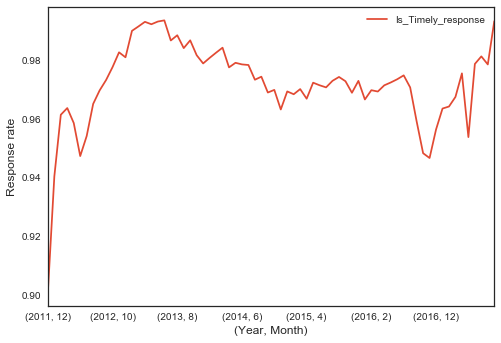

In [43]:
trend = data[['receive_year', 'receive_month', 'Is_Timely_response']]
trend.groupby(['receive_year', 'receive_month']).mean().plot()
plt.xlabel('(Year, Month)')
plt.ylabel('Response rate')
plt.show()

This plot shows the trend of response rate. We could notice that it goes up quickly from Dec 2011, and reach a peak at May or Jun 2013. and then goes down slowly till Nov 2016, then grows again till 2017.

---

These plots show the trend of response rate in year- /month- scale. The bule line is the mean response rate.

- There's a drop in 2011, that is because there is only one month (December) of records in 2011. 

- There're two drops in May and Sep - Dec. But still in a resonable range.

In [46]:
def yearly_response_rate(year):
    d = data[data.receive_year == year]
    rate = d.Is_Timely_response.mean()
    return rate

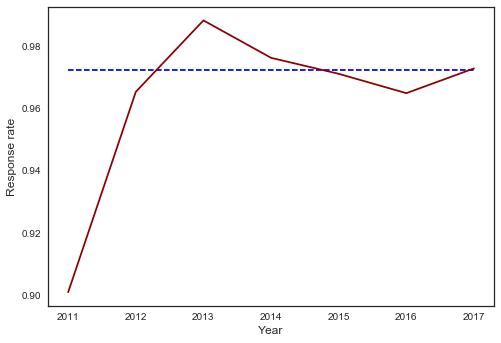

In [47]:
year = [2011,2012,2013,2014,2015,2016,2017]
yearly_res_rate = [yearly_response_rate(i) for i in year]

#plt.bar(year,yearly_res_rate,align='center', alpha=0.5)
tr_base = np.array([mean for i in range(len(year))])

plt.plot(year, tr_base, 'b--')


plt.plot(year,yearly_res_rate,'darkred')
plt.xlabel('Year')
plt.ylabel('Response rate')

plt.show()

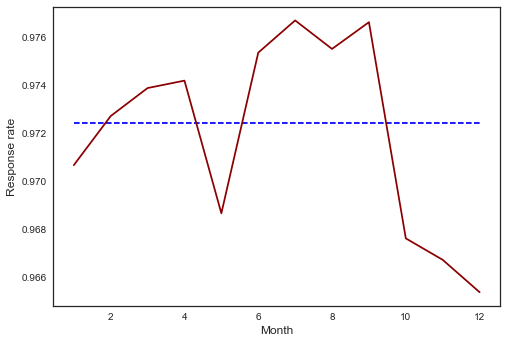

In [45]:
month=[]
for i in range(12):
    month.append(i+1) 

def monthly_response_rate(month):
    d = data[data.receive_month == month]
    rate = d.Is_Timely_response.mean()
    return rate

monthly_res_rate = [monthly_response_rate(i) for i in month]

#plt.bar(year,yearly_res_rate,align='center', alpha=0.5)
tr_base = np.array([mean for i in range(len(month))])

plt.plot(month, tr_base, 'b--')


plt.plot(month,monthly_res_rate,'darkred')
plt.xlabel('Month')
plt.ylabel('Response rate')

plt.show()

## Feature Engineering

In [49]:
def mean_rate_by_cat(data, cat):
    '''
    Input: data is the whole data set;
           cat is the categorical feature you want to calculate mean response rate (rate of 1).
    Output: a dataframe
    '''
    
    cat = str(cat)
    
    # Calculate mean response rate of each cat
    mean_rate_by_cat = data.groupby('%s'%cat).mean()
    
    # reset index
    mean_rate_by_cat['%s'%cat] = mean_rate_by_cat.index
    mean_rate_by_cat.columns = ['mean_response_rate_by_%s'%cat, '%s'%cat]
    mean_rate_by_cat = mean_rate_by_cat.reset_index(drop=True)
    
    # Calculate mean response rate of each cat
    mean_rate_by_cat['mean_response_rate_over_avg_by_%s'%cat] = mean_rate_by_cat['mean_response_rate_by_%s'%cat] / 0.972434 - 1

    return mean_rate_by_cat

In [51]:
def freq_by_cat(data, cat):
    '''
    Input: data is the whole data set;
           cat is the categorical feature you want to calculate the frequency of each category inside this feature.
    Output: a dataframe
    '''
    
    cat = str(cat)
    # Calculate the frequency of each cat
    freq = data.groupby('%s'%cat).count()/860606
    # reset index
    freq['%s'%cat] = freq.index
    freq.columns = ['freq_by_%s'%cat, '%s'%cat]
    freq = freq.reset_index(drop=True)
    
    return freq

** Time **<br>

New features:
- year: Complaint year
- month: Complaint month
- days_spend: Days spend for transferring the complaint from CFPB to company
- mean_rate_over_avg_by_time: Mean response rate groupby month/year over average
- mean_rate_by_time: Mean response rate groupby month/year

In [52]:
# Time 
data.Date_received = pd.to_datetime(data.Date_received)
data.Date_sent_to_company = pd.to_datetime(data.Date_sent_to_company)

# Using np array in order to calcalate quicker
rece = np.array(data.Date_received)
sent = np.array(data.Date_sent_to_company)
days = (sent - rece).astype('timedelta64[D]') / np.timedelta64(1, 'D')

# New feature: days_spend
data['days_spend'] = days

# New features: year and month
data['year'] = data.Date_received.dt.year
data['month'] = data.Date_received.dt.month

In [53]:
time = data[['year','month','Is_Timely_response']]

# Calculate mean response rate by month and year
mean_rate_by_time = time.groupby(['year','month']).mean()
mean_rate_by_time.columns = ['mean_rate_by_time']

# reset index
mean_rate_by_time = mean_rate_by_time.reset_index(level=['year', 'month'])
mean_rate_by_time['mean_rate_over_avg_by_time'] = mean_rate_by_time.mean_rate_by_time - 0.972434

# Two new features: mean_rate_over_avg_by_time, mean_rate_by_time
data = pd.merge(data, mean_rate_by_time, on=['year','month'])

** Company **<br>

New features:
- complaint_scale: 1~5. Measured by number of complaints
- mean_response_rate_by_company: Mean response rate groupby company over average
- mean_rate_over_avg_by_company: Mean response rate groupby company
- freq_by_company: Frequency of company

In [55]:
# Extract Company 
company = data[['Company', 'Is_Timely_response']]
company = company.groupby('Company').count()
company = company.sort('Is_Timely_response', ascending=False)
company.columns = ['complaint_count']

# Scale Company based on number of complaints
scale1 = company[company.complaint_count<=10].index
scale10 = company[(company.complaint_count<=100) & (company.complaint_count>10)].index
scale100 = company[(company.complaint_count<=1000) & (company.complaint_count>100)].index
scale1000 = company[(company.complaint_count<=10000) & (company.complaint_count>1000)].index
scale10000 = company[company.complaint_count>10000].index

# Encode number of complaints
s1 = pd.DataFrame(index=scale1,data=np.ones(len(scale1)))
s10 = pd.DataFrame(index=scale10,data=2*np.ones(len(scale10)))
s100 = pd.DataFrame(index=scale100,data=3*np.ones(len(scale100)))
s1000 = pd.DataFrame(index=scale1000,data=4*np.ones(len(scale1000)))
s10000 = pd.DataFrame(index=scale10000,data=5*np.ones(len(scale10000)))

# Create complaint_scale data frame 
scale = pd.concat([s1,s10,s100,s1000,s10000])
scale.columns = ['complaint_scale']
scale['Company'] = scale.index

# New feature: complaint_scale
data = pd.merge(data, scale, on='Company')

In [56]:
company = data[['Company', 'Is_Timely_response']]

mean_rate_by_company = mean_rate_by_cat(company, 'Company')
freq_by_company = freq_by_cat(company, 'Company')

# Two new features: mean_response_rate_by_company, mean_rate_over_avg_by_company
data = pd.merge(data, mean_rate_by_company, on='Company')
# One new feature: freq_by_company
data = pd.merge(data, freq_by_company, on='Company')

** Is_Consumer_disputed **

In [57]:
data.Is_Consumer_disputed[data.Is_Consumer_disputed == 'Yes'] = 1
data.Is_Consumer_disputed[data.Is_Consumer_disputed == 'No'] = 0
data.Is_Consumer_disputed[data.Is_Consumer_disputed == 'NotKnow'] = -1

In [58]:
Is_Consumer_disputed = data[['Is_Consumer_disputed', 'Is_Timely_response']]

mean_rate_by_disput = mean_rate_by_cat(Is_Consumer_disputed, 'Is_Consumer_disputed')
freq_by_disput = freq_by_cat(Is_Consumer_disputed, 'Is_Consumer_disputed')

# Two new features: mean_response_rate_by_issue, mean_rate_over_avg_by_issue
data = pd.merge(data, mean_rate_by_disput, on='Is_Consumer_disputed')
# One new feature: freq_by_issue
data = pd.merge(data, freq_by_disput, on='Is_Consumer_disputed')

** Issue **<br>

New features:
- mean_response_rate_by_issue: Mean response rate groupby issue
- mean_rate_over_avg_by_issue: Mean response rate groupby issue over average
- freq_by_issue: Frequency of issue

In [59]:
issue = data[['Issue', 'Is_Timely_response']]

mean_rate_by_issue = mean_rate_by_cat(issue, 'Issue')
freq_by_issue = freq_by_cat(issue, 'Issue')

# Two new features: mean_response_rate_by_issue, mean_rate_over_avg_by_issue
data = pd.merge(data, mean_rate_by_issue, on='Issue')
# One new feature: freq_by_issue
data = pd.merge(data, freq_by_issue, on='Issue')

** Product **<br>

New features:
- mean_response_rate_by_product: Mean response rate groupby product
- mean_rate_over_avg_by_product: Mean response rate groupby product over average
- freq_by_product: Frequency of product

In [60]:
product = data[['Product', 'Is_Timely_response']]

mean_rate_by_product = mean_rate_by_cat(product, 'Product')
freq_by_product = freq_by_cat(product, 'Product')

# Two new features: mean_response_rate_by_product, mean_rate_over_avg_by_product
data = pd.merge(data, mean_rate_by_product, on='Product')
# One new feature: freq_by_product
data = pd.merge(data, freq_by_product, on='Product')

** State **<br>

New features:
- mean_response_rate_by_state: Mean response rate groupby State
- mean_rate_over_avg_by_State: Mean response rate groupby State over average
- freq_by_product: Frequency of State

In [61]:
State = data[['State', 'Is_Timely_response']]

mean_rate_by_State = mean_rate_by_cat(State, 'State')
freq_by_State = freq_by_cat(State, 'State')

# Two new features: mean_response_rate_by_state, mean_rate_over_avg_by_state
data = pd.merge(data, mean_rate_by_State, on='State')
# One new feature: freq_by_state
data = pd.merge(data, freq_by_State, on='State')

** ZIP_Code **<br>

New features:
- mean_response_rate_by_ZIP_code: Mean response rate groupby ZIP_code
- mean_rate_over_avg_by_ZIP_code: Mean response rate groupby ZIP_code over average
- freq_by_ZIP_code: Frequency of ZIP_code

In [63]:
ZIP_code = data[['ZIP_code', 'Is_Timely_response']]

mean_rate_by_ZIP_code = mean_rate_by_cat(ZIP_code, 'ZIP_code')
freq_by_ZIP_code = freq_by_cat(ZIP_code, 'ZIP_code')

# Two new features: mean_response_rate_by_zipcode, mean_rate_over_avg_by_zipcode
data = pd.merge(data, mean_rate_by_ZIP_code, on='ZIP_code')
# One new feature: freq_by_zipcode
data = pd.merge(data, freq_by_ZIP_code, on='ZIP_code')

** One-hot encoding **

In [64]:
dummies = pd.get_dummies(data[[1,2,4,6]])

In [65]:
data = data.drop(
    ['Date_received', 'ZIP_code', 'Date_sent_to_company', 
     'Complaint_ID', 'Company', 'Product', 'Issue', 'State', 
     'Submitted_via', 'Company_response_to_consumer'], 1
)

In [66]:
data = pd.concat([data,dummies],1,join='inner')
data.head(3)

(860606, 280)

In [68]:
# delete duplicated features
data = data.drop(['receive_year','receive_month'],1)

In [79]:
data.Is_Consumer_disputed = data.Is_Consumer_disputed.astype('int')

## Model Building

** 1. Set Seed **

In [71]:
# global seed
rs = 20171101
np.random.seed(rs)

** 2. Split training, validation and test set **<br>
- training set: 72.25%
- validation set: 12.75%
- test set: 15%

In [70]:
train_len = int(data.shape[0] * 0.7)
train_len

602424

In [127]:
train_len = int(data.shape[0] * 0.85)

train = data.iloc[:train_len,:]
test = data.iloc[train_len: ,:]

print('Training set shape:', train.shape)
print('Test set shape:', test.shape)

Training set shape: (731515, 278)
Test set shape: (129091, 278)


In [128]:
label = train.Is_Timely_response
del train['Is_Timely_response']

X_train, X_val, y_train, y_val = train_test_split(
    train, label, 
    test_size = 0.15, 
    random_state = rs)

In [129]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

X_train shape: (621787, 277)
X_val shape: (109728, 277)
y_train shape: (621787,)
y_val shape: (109728,)


In [130]:
y_test = test.Is_Timely_response
X_test = test.drop('Is_Timely_response', 1)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (129091, 277)
y_test shape: (129091,)


** 3. Model Building **

** 3.1 Light GBM **

In [84]:
sens=[]
accu=[]
for rounds in [600,800,1000,1200,1400,1600,1800,2000,2200,2400]:
    param  = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'feature_fraction_seed': rs,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'bagging_seed': rs,
    'num_boost_round': rounds
    }
    
    start_time = time.time()

    data_lgb = lgb.Dataset(X_train, y_train)
    lgbm = lgb.train(param, data_lgb)
    pred = lgbm.predict(X_val)

    pred[pred > 0.5] = 1
    pred[pred < 0.5] = 0

    conf_mat = confusion_matrix(y_val, pred)
    acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
    sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])

    print('Round = %i:'%rounds)
    print('======================')
    print('Accuracy:', acc)

    sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
    print('Sensitivity:', sen)
    print('Running time:', (time.time() - start_time))
    print('')
    
    sens.append(sen)
    accu.append(acc)

Round = 600:
Accuracy: 0.980715952173
Sensitivity: 0.400341296928
Running time: 56.35334396362305

Round = 800:
Accuracy: 0.980788859726
Sensitivity: 0.404436860068
Running time: 61.192903995513916

Round = 1000:
Accuracy: 0.980761519393
Sensitivity: 0.404778156997
Running time: 71.84318995475769

Round = 1200:
Accuracy: 0.980870880723
Sensitivity: 0.407508532423
Running time: 76.40376806259155

Round = 1400:
Accuracy: 0.980934674832
Sensitivity: 0.41023890785
Running time: 91.46891593933105

Round = 1600:
Accuracy: 0.980971128609
Sensitivity: 0.412627986348
Running time: 101.51315784454346

Round = 1800:
Accuracy: 0.980998468941
Sensitivity: 0.414675767918
Running time: 90.52910614013672

Round = 2000:
Accuracy: 0.980934674832
Sensitivity: 0.414675767918
Running time: 98.48785781860352

Round = 2200:
Accuracy: 0.980852653835
Sensitivity: 0.411604095563
Running time: 109.23441481590271

Round = 2400:
Accuracy: 0.98079797317
Sensitivity: 0.409897610922
Running time: 119.76606488227844



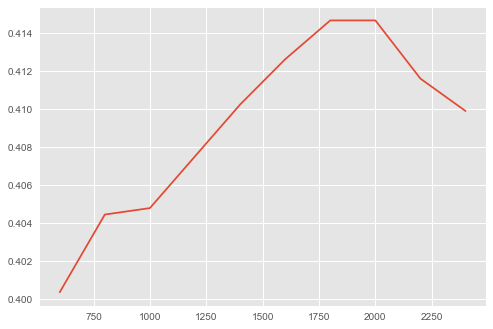

In [85]:
rounds = [600,800,1000,1200,1400,1600,1800,2000,2200,2400]

plt.plot(rounds,sens)
#plt.plot(rounds,accu)
plt.show()

In [86]:
rounds = 1800

param  = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'feature_fraction_seed': rs,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'bagging_seed': rs,
    'num_boost_round': rounds
}

In [87]:
start_time = time.time()

data_lgb = lgb.Dataset(X_train, y_train)
lgbm = lgb.train(param, data_lgb)
pred = lgbm.predict(X_val)

print("### %s seconds ###" % (time.time() - start_time))

### 86.09136390686035 seconds ###


** CV **

In [88]:
start_time = time.time()

data_lgbm_cv = lgb.Dataset(train, label)
lgbm_cv = lgb.cv(param, data_lgbm_cv, num_boost_round=100, nfold=10)

print("### %s seconds ###" % (time.time() - start_time))

### 78.39570498466492 seconds ###


In [89]:
len(lgbm_cv['binary_logloss-mean'])

100

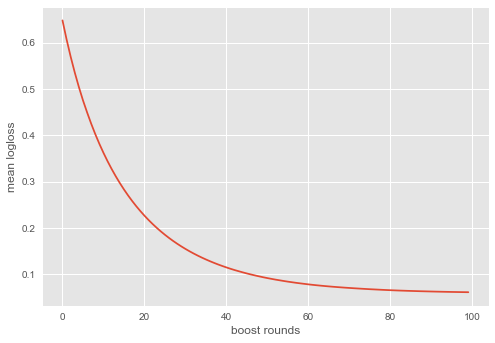

In [90]:
logloss = lgbm_cv['binary_logloss-mean']
x = range(100)

plt.plot(x,logloss)
plt.xlabel('boost rounds')
plt.ylabel('mean logloss')
plt.show()

** ROC **

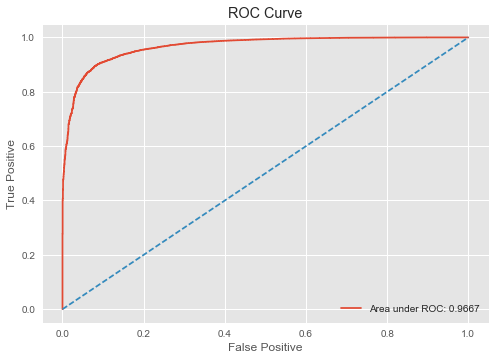

In [91]:
fp, tp, thr = roc_curve(y_val, pred)
score = roc_auc_score(y_val,pred)

plt.plot(fp, tp, label='Area under ROC: %0.4f'%score)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

** Accuracy and Sensitivity **

In [92]:
pred[pred > 0.5] = 1
pred[pred < 0.5] = 0

conf_mat = confusion_matrix(y_val, pred)
acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
print('Accuracy:', acc)

sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen)

Accuracy: 0.980998468941
Sensitivity: 0.414675767918


**Accuracy and Sensitivity on Test Set **

In [131]:
pred_lgbm = lgbm.predict(X_test)

pred_lgbm[pred_lgbm > 0.5] = 1
pred_lgbm[pred_lgbm < 0.5] = 0

conf_mat = confusion_matrix(y_test, pred_lgbm)
acc_lgbm = (conf_mat[0][0] + conf_mat[1][1])/len(y_test)
print('Accuracy:', acc_lgbm)

sen_lgbm = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen_lgbm)

Accuracy: 0.980254239258
Sensitivity: 0.489085239085


In [132]:
conf_mat

array([[  1882,   1966],
       [   583, 124660]])

** 3.2 Xgboost **

In [93]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val)

In [94]:
sens = []
accu = []
for eta in [100,150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]:
    param = {
    'max_depth': 20, 
    'eta': eta, 
    'silent': 1, 
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc'
    }
    
    start_time = time.time()
    
    #num_round = rounds
    bst = xgb.train(param, dtrain, num_boost_round=10)
    
    pred_xgb = bst.predict(dtest)
    
    #pred_xgb[pred_xgb > 0.5] = 1
    #pred_xgb[pred_xgb < 0.5] = 0

    conf_mat = confusion_matrix(y_val, pred_xgb.astype(int))
    acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
    
    print('Eta = %i:'%eta)
    print('======================')
    print('Accuracy:', acc)

    sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
    print('Sensitivity:', sen)
    print('Running time:', (time.time() - start_time))
    print('')
    
    sens.append(sen)
    accu.append(acc)

Eta = 100:
Accuracy: 0.975402814232
Sensitivity: 0.269965870307
Running time: 68.11903810501099

Eta = 150:
Accuracy: 0.977334864392
Sensitivity: 0.291467576792
Running time: 63.062554121017456

Eta = 200:
Accuracy: 0.91867162438
Sensitivity: 0.674744027304
Running time: 63.30255389213562

Eta = 250:
Accuracy: 0.976778944299
Sensitivity: 0.266552901024
Running time: 74.47719216346741

Eta = 300:
Accuracy: 0.977845217265
Sensitivity: 0.30204778157
Running time: 77.82956385612488

Eta = 350:
Accuracy: 0.977726742491
Sensitivity: 0.301023890785
Running time: 63.61158514022827

Eta = 400:
Accuracy: 0.979002624672
Sensitivity: 0.356996587031
Running time: 62.05333995819092

Eta = 450:
Accuracy: 0.942649095946
Sensitivity: 0.638566552901
Running time: 62.16544699668884

Eta = 500:
Accuracy: 0.951069918344
Sensitivity: 0.635494880546
Running time: 62.09984111785889

Eta = 550:
Accuracy: 0.951069918344
Sensitivity: 0.635494880546
Running time: 61.83918809890747

Eta = 600:
Accuracy: 0.95106991

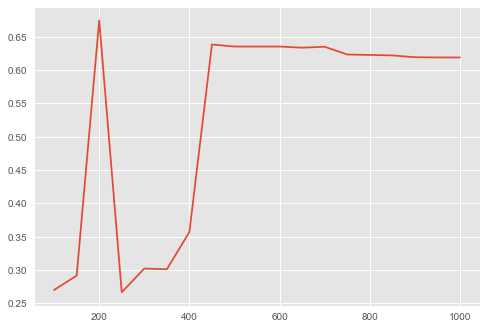

In [96]:
eta = [100,150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

plt.plot(eta,sens)
#plt.plot(eta,accu)
plt.show()

In [97]:
param = {
    'max_depth': 20, 
    'eta': 500, 
    'silent': 1, 
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc'
}
#param['nthread'] = 4
#param['eval_metric'] = ['auc', 'ams@0']

In [98]:
start_time = time.time()

num_round = 10
bst = xgb.train(param, dtrain, num_boost_round=num_round)
pred_xgb = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

print("--- %s seconds ---" % (time.time() - start_time))

--- 65.36633586883545 seconds ---


In [ ]:
conf_mat = confusion_matrix(y_val, pred_xgb.astype(int))
acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
print('Accuracy:', acc)

sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen)

In [100]:
conf_mat

array([[  1862,   1068],
       [  4301, 102497]])

** Accuracy and Sensitivity on Test Set**

In [134]:
ddtest = xgb.DMatrix(X_test)

pred_xgb = bst.predict(ddtest, ntree_limit=bst.best_ntree_limit)

conf_mat = confusion_matrix(y_test, pred_xgb.astype(int))
acc_xgb = (conf_mat[0][0] + conf_mat[1][1])/len(y_test)
print('Accuracy:', acc_xgb)

sen_xgb = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen_xgb)

Accuracy: 0.918073297131
Sensitivity: 0.706600831601


In [110]:
conf_mat

array([[  2719,   1129],
       [  9447, 115796]])

** CV **

In [ ]:
xgb_cv = xgb.cv(param, dtrain=dtrain, nfold=10, as_pandas=1, seed=rs)
xgb_cv

** 3.3 GBT**

In [105]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.time()

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_val)

print("--- %s seconds ---" % (time.time() - start_time))

--- 583.9718470573425 seconds ---


In [107]:
conf_mat = confusion_matrix(y_val, pred)
acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
print('Accuracy:', acc)

sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen)

Accuracy: 0.979777267425
Sensitivity: 0.357679180887


** Accuracy and Sensitivity on Test Set**

In [135]:
pred_gbt = clf.predict(X_test)

conf_mat = confusion_matrix(y_test, pred_gbt)
acc_gbt = (conf_mat[0][0] + conf_mat[1][1])/len(y_test)
print('Accuracy:', acc_gbt)

sen_gbt = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen_gbt)

Accuracy: 0.979131000612
Sensitivity: 0.448024948025


In [112]:
conf_mat

array([[  1724,   2124],
       [   570, 124673]])

** 3.4 Logistic Regression **

Normalize data and split train, validation and test set again

In [114]:
label = data.Is_Timely_response
X = normalize(data.drop('Is_Timely_response',1))

Apply PCA to our dataset and reduce the features to 30.

In [115]:
pca = PCA(n_components=30)
pca.fit(X)

X_pca = pca.transform(X)
X_pca.shape

(860606, 30)

In [116]:
cols = []
for i in range(30):
    cols.append('PCA_%i'%(i+1))

X_pca = pd.DataFrame(X_pca)
X_pca.columns = cols

In [117]:
X_pca['Is_Timely_response'] = label
data_pca = X_pca

train_len = int(data_pca.shape[0] * 0.85)

train = data_pca.iloc[:train_len,:]
test = data_pca.iloc[train_len: ,:]

print('Training set shape:', train.shape)
print('Test set shape:', test.shape)

Training set shape: (731515, 31)
Test set shape: (129091, 31)


In [118]:
label = train.Is_Timely_response
del train['Is_Timely_response']

X_train, X_val, y_train, y_val = train_test_split(
    train, label, 
    test_size = 0.15, 
    random_state = rs)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

X_train shape: (621787, 30)
X_val shape: (109728, 30)
y_train shape: (621787,)
y_val shape: (109728,)


In [119]:
y_test = test.Is_Timely_response
X_test = test.drop('Is_Timely_response',1)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (129091, 30)
y_test shape: (129091,)


Training logistic regression model

In [120]:
lr = LogisticRegression(random_state=rs)
lr.fit(X_train, y_train)
pred = lr.predict(X_val)

In [121]:
conf_mat = confusion_matrix(y_val, pred)
acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
print('Accuracy:', acc)

sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen)

Accuracy: 0.9732702683
Sensitivity: 0.0


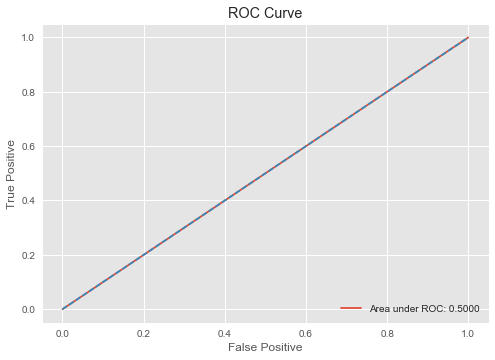

In [122]:
fp, tp, thr = roc_curve(y_val, pred)
score = roc_auc_score(y_val,pred)

plt.plot(fp, tp, label='Area under ROC: %0.4f'%score)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

** Accuracy and Sensitivity on Test Set **

In [125]:
pred_lr = lr.predict(X_test)

conf_mat = confusion_matrix(y_test, pred_lr)
acc_lr = (conf_mat[0][0] + conf_mat[1][1])/len(y_test)
print('Accuracy:', acc_lr)

sen_lr = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen_lr)

Accuracy: 0.970176077341
Sensitivity: 0.0


## Comparing

In [137]:
models = ['LightGBM', 'Xgboost', 'Gradient Boosted Tree', 'Logistic Regression']
accuracy= [acc_lgbm, acc_xgb, acc_gbt, acc_lr]
sensitivity = [sen_lgbm, sen_xgb, sen_gbt, sen_lr]

results = pd.DataFrame([accuracy,sensitivity])
results.columns = models
results.index = ['Accuracy', 'Sensitivity']

In [138]:
results

,LightGBM,Xgboost,Gradient Boosted Tree,Logistic Regression
Accuracy,0.980254,0.918073,0.979131,0.970176
Sensitivity,0.489085,0.706601,0.448025,0.000000


## Further Works

- Do more feature engineering
- Tune these models to achieve better results
- Ensemble